Specific about this notebook:
- Use data file sim_noisy_pulse.lc
- Fit the model on a subset (e.g. N/4) of the data, predict on the other 4-1 parts.
- Measure fit
- Try three different downsampling techniques:
  - Downsampling taking every 3rd point
  - Downsampling using a Fourier method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
  - Downsampling using uniform random sampling
  - Evaluate which of the three downsampled datasets matches the original one the most by comparing the Lomb-Scargle periodogram of all.

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from scipy import signal

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Read the time series

In [3]:
df = pd.read_csv("../../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)
N=X.shape[0]

## Plot the data and the Lomb Scargle periodogram of the full dataset

In [5]:
def plot_data(X, Y):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])
    
def plot_lomb_scargle_periodogram(x, y, min_freq, max_freq, frequencies=None):
    if frequencies is not None:
        power = LombScargle(x, y).power(frequencies)
    else:
        frequencies, power = LombScargle(x, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    plt.figure(figsize=(35, 5))
    plt.plot(frequencies, power)
    plt.xlabel("frequency"), plt.ylabel("power")
    return frequencies, power

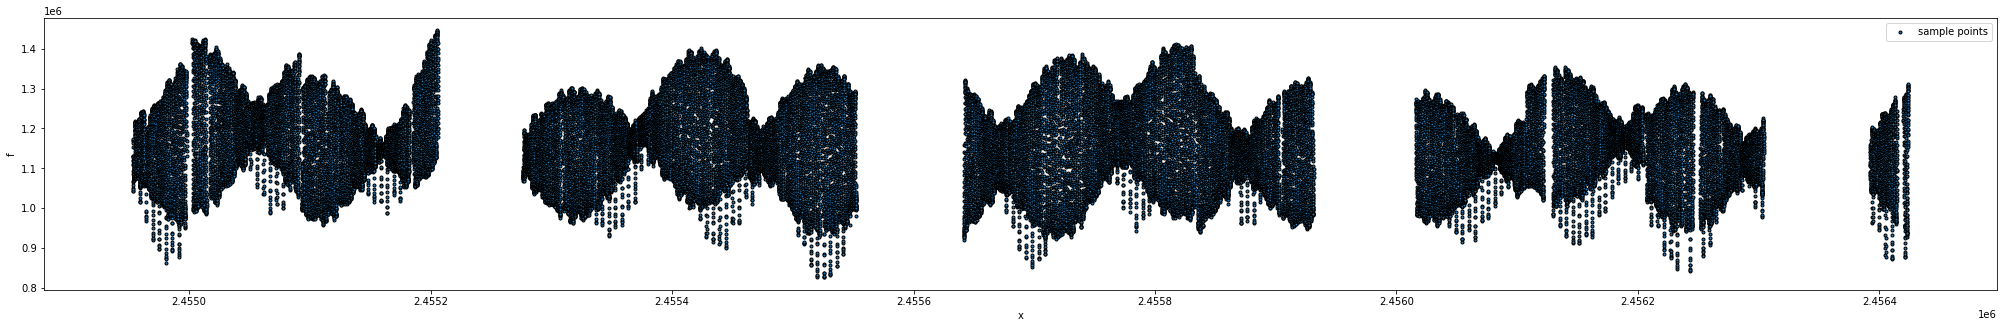

In [6]:
plot_data(X, Y)

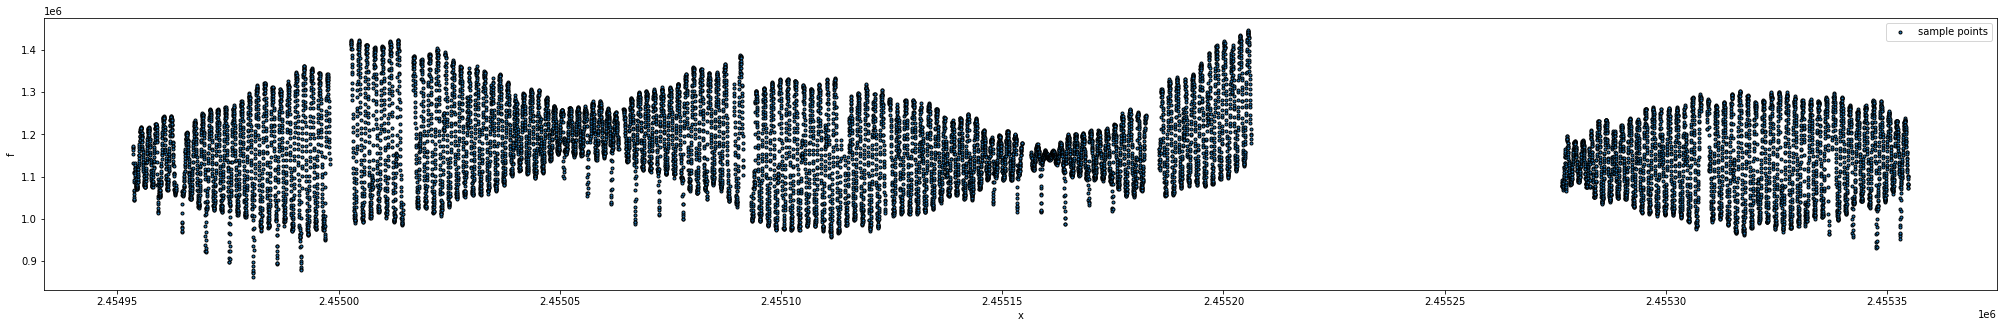

In [25]:
plot_data(X[:15000], Y[:15000])

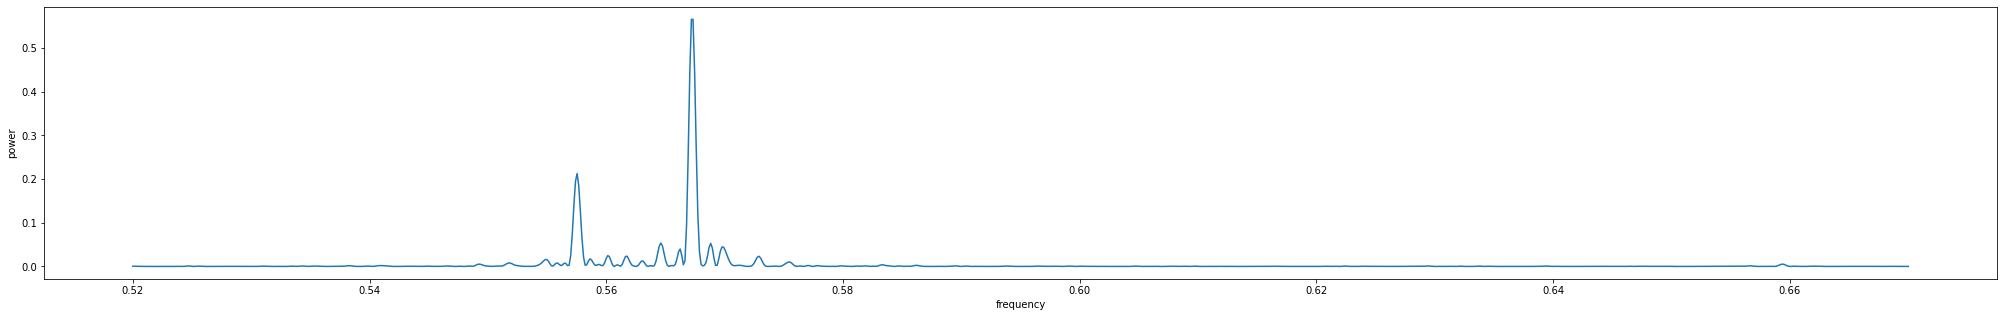

In [7]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.52, 0.67)

## Downsample using uniform random sampling of 25% of the dataset

In [8]:
# Take an uniformly distributed sample of size N/4. Sort the indexes so we can
# plot the first part of the data.
sample_idcs = np.random.choice(N, size=N//4)
sample_idcs.sort()

X_part, Y_part = X[sample_idcs], Y[sample_idcs]
N_sampled = X_part.shape[0]   # Use a number that can be divided by 4. N//4
N_sampled

12993

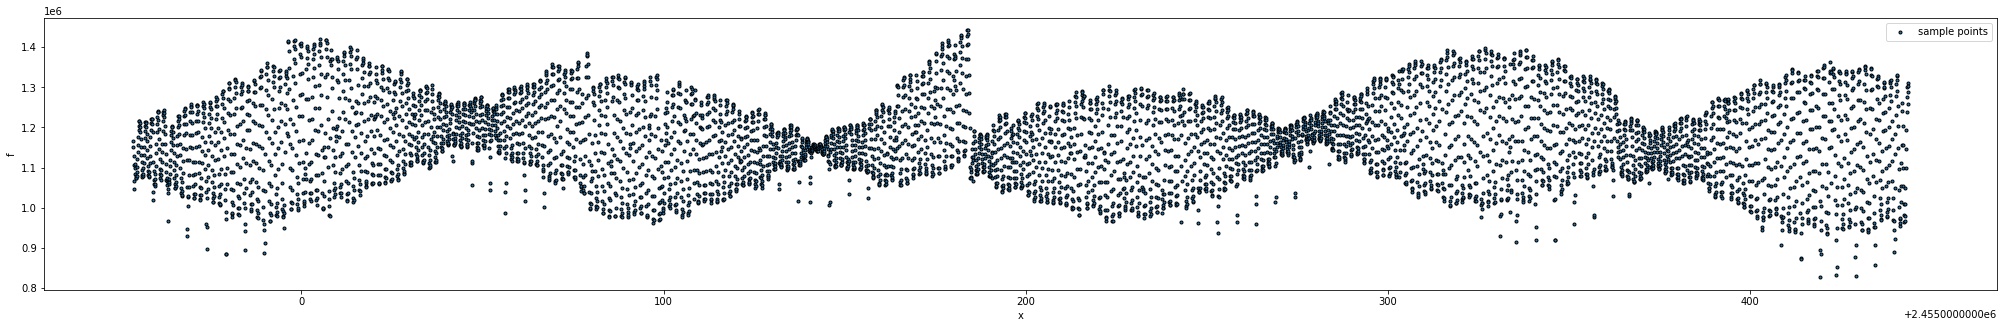

In [23]:
plot_data(X_part[:6000], Y_part[:6000])

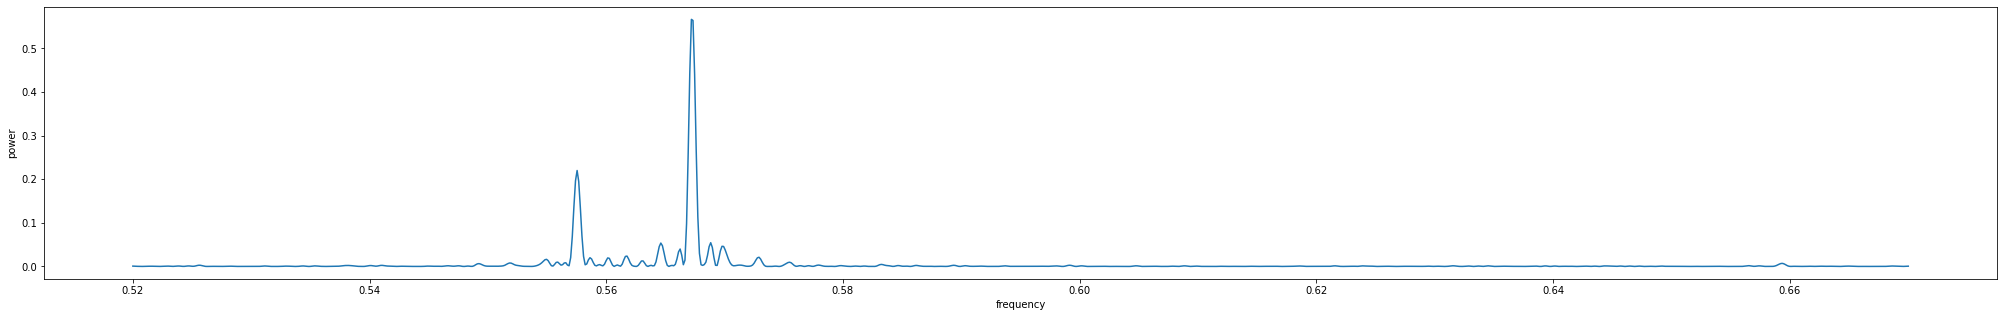

In [10]:
fp_random = plot_lomb_scargle_periodogram(X_part, Y_part, 0.52, 0.67, frequencies)

## Downsample using even sampling of 25%

In [11]:
X_part, Y_part = X[1::4], Y[1::4]
N_sampled = X_part.shape[0]   # Use a number that can be divided by 4. N//4
N_sampled

12993

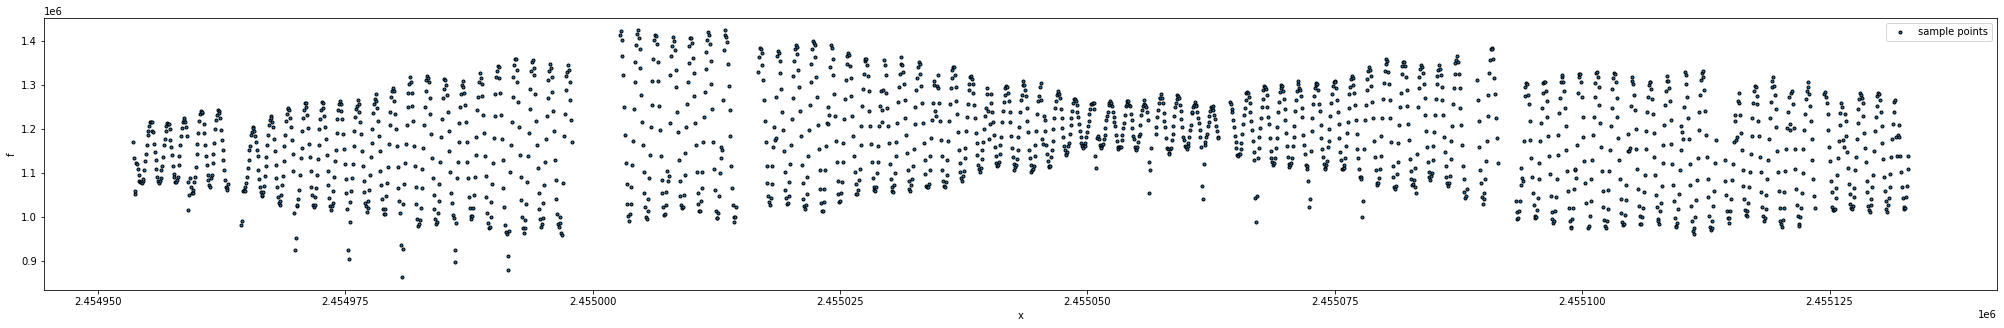

In [12]:
plot_data(X_part[:2000], Y_part[:2000])

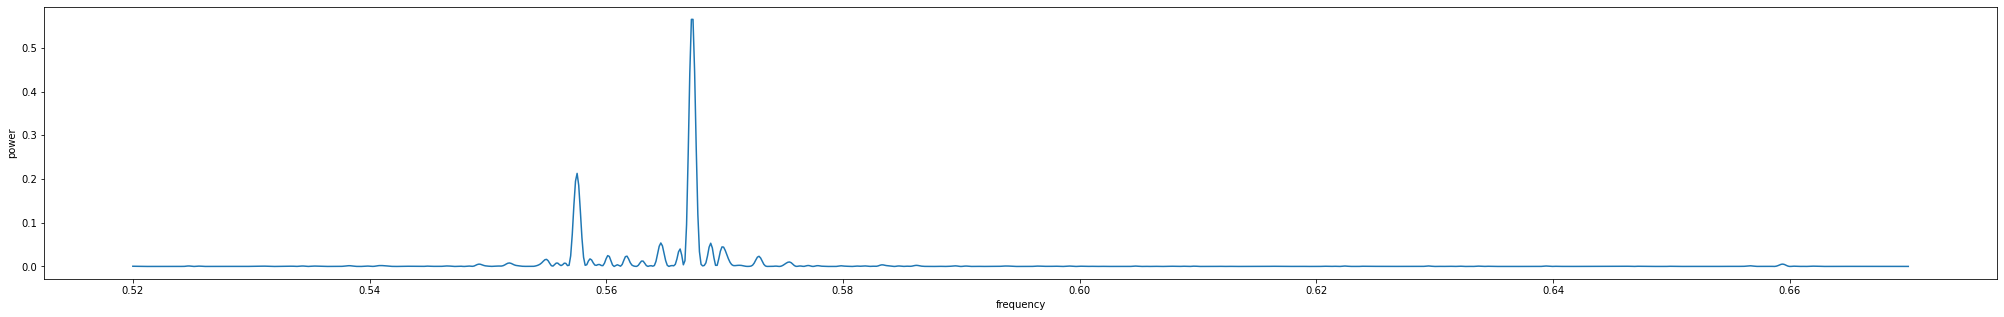

In [13]:
fp_even = plot_lomb_scargle_periodogram(X_part, Y_part, 0.52, 0.67, frequencies)

## Downsampling using Fourier sampling

In [14]:
N_sampled = 13000   # Use a number that can be divided by 4. N//4
X, Y = np.array(X), np.array(Y)
Y_part, X_part = signal.resample(x=Y, t=X, num=N_sampled)

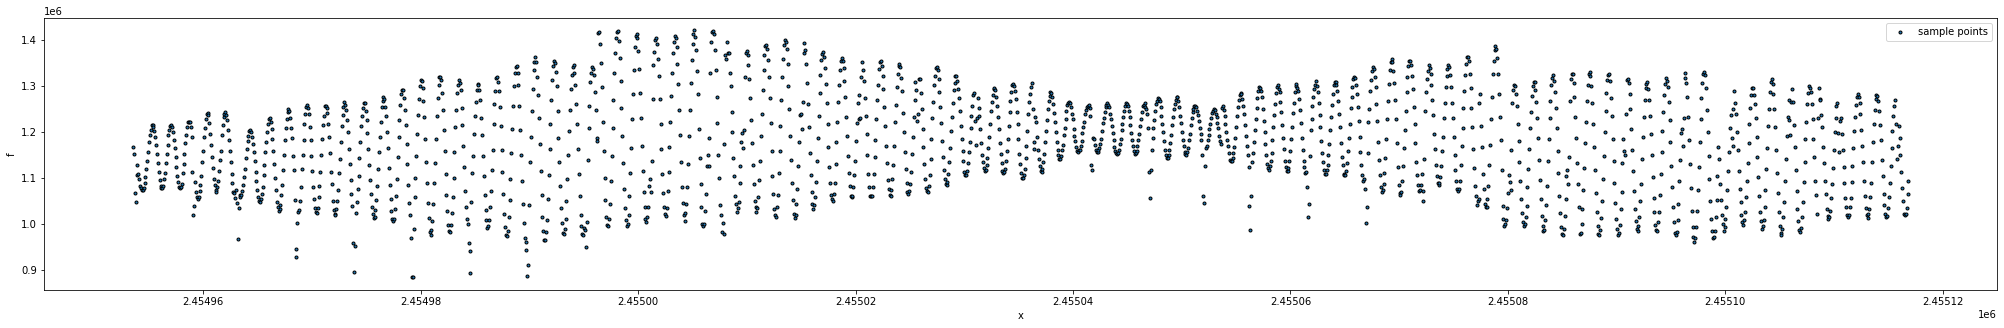

In [15]:
plot_data(X_part[:2000], Y_part[:2000])

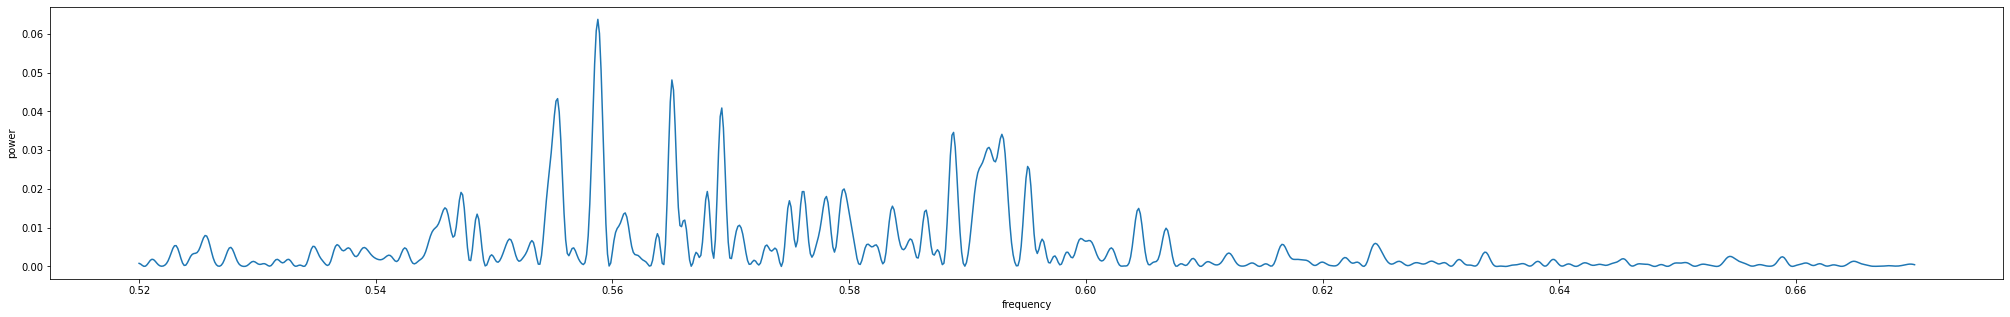

In [16]:
fp_fourier = plot_lomb_scargle_periodogram(X_part, Y_part, 0.52, 0.67, frequencies)

In [17]:
assert frequencies.shape == fp_even[0].shape == fp_random[0].shape == fp_fourier[0].shape
assert power.shape == fp_even[1].shape == fp_random[1].shape == fp_fourier[1].shape

# Compare the three periodograms

The power axis in the periodogram are all positive values, so we don not need to square or abs.
Note that we have calculated the power at exactly the same frequencies, so we have 4 periodograms of equal length that can be pairwise compared for each frequency. 

In [18]:
ts_orig = pd.DataFrame()
ts_orig['freq'] = frequencies.tolist()
ts_orig['power'] = power.tolist()

In [19]:
ts_even = pd.DataFrame()
ts_even['freq'] = fp_even[0].tolist()
ts_even['power'] = fp_even[1].tolist()

In [20]:
ts_random = pd.DataFrame()
ts_random['freq'] = fp_random[0].tolist()
ts_random['power'] = fp_random[1].tolist()

In [21]:
ts_fourier = pd.DataFrame()
ts_fourier['freq'] = fp_fourier[0].tolist()
ts_fourier['power'] = fp_fourier[1].tolist()

In [22]:
results = [ ('even', ts_orig.corrwith(ts_even)['power']),
            ('random', ts_orig.corrwith(ts_random)['power']),
            ('fourier', ts_orig.corrwith(ts_fourier)['power']) ]
results

[('even', 0.9999995655674706),
 ('random', 0.9997214540574916),
 ('fourier', 0.022617373906376137)]

The even sampling comes out with the highest correlation!!